# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [71]:
# IMPORTANDO AS BIBLIOTECAS E PACOTES NECESSÁRIOS
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

%matplotlib inline


In [72]:
# Carregando as bases lidas na tarefa anterior com seus respectivos índices

# Carregar os dados de treinamento
X_train = pd.read_csv('/content/X_train.csv', index_col=['Unnamed: 0', 'subject_train'])
y_train = (pd.read_csv('/content/y_train.txt', header=None).squeeze('columns'))

# Carregando os dados de teste
X_test = pd.read_csv('/content/X_test.csv', index_col=['Unnamed: 0', 'subject_test'])
y_test = (pd.read_csv('/content/y_test.txt', header=None).squeeze('columns'))

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [73]:
# Dividindp a base de treino em um novo conjunto de treino e um conjunto de validação
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# test_size=0.25 indica que 25% da base de treino será usada como base de validação.
# O argumento random_state=42 é usado para garantir que a divisão seja reproduzível.
# Se executar o código várias vezes, obterá a mesma divisão todas as vezes.

# Exibindo o tamanho das bases
print("Tamanho de X_train_new:", X_train_new.shape)
print("Tamanho de X_val:", X_val.shape)


Tamanho de X_train_new: (5514, 561)
Tamanho de X_val: (1838, 561)


### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [74]:
# Criando um modelo de árvore de decisão com profundidade máxima igual a 4
clf = DecisionTreeClassifier(max_depth=4, random_state=42)

# Treinando o modelo com os dados de treinamento originais (X_train e y_train)
clf.fit(X_train_new, y_train_new)

# Obtendo a importância das variáveis e classificá-las
feature_importance_df = pd.DataFrame({'var': X_train.columns, 'feature_importances_': clf.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='feature_importances_', ascending=False)

# Obtendo as três variáveis mais importantes
top_3_features = feature_importance_df['var'].values[:3]

print("As três variáveis mais importantes são:")
for feature in top_3_features:
    print(feature)



As três variáveis mais importantes são:
53 tGravityAcc-min()-X
390 fBodyAccJerk-bandsEnergy()-1,16
42 tGravityAcc-mean()-Y


### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

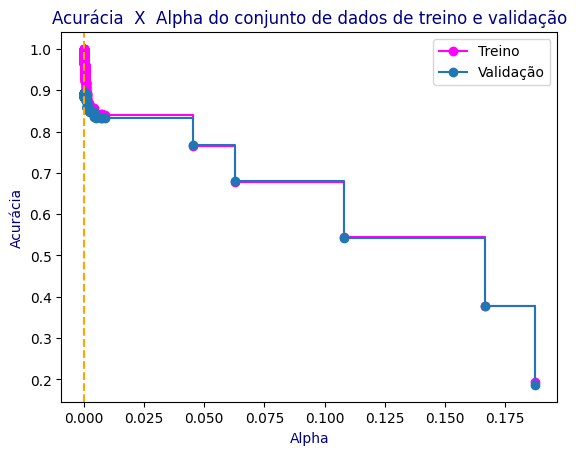

O melhor ccp_alpha encontrado é: 0.0002747826469262813
CPU times: user 7.19 s, sys: 76.9 ms, total: 7.27 s
Wall time: 7.22 s


In [80]:
%%time

# Selecionando apenas as três variáveis mais importantes
cols = ['53 tGravityAcc-min()-X', '390 fBodyAccJerk-bandsEnergy()-1,16', '42 tGravityAcc-mean()-Y']
X_train_top3 = X_train_new[cols]
X_val_top3 = X_val[cols]

# Obtendo o caminho de poda de complexidade de custo
# Isso retorna os valores de ccp_alpha e as impurezas correspondentes
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X=X_train_top3, y=y_train_new)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Criando uma lista para armazenar os classificadores para cada valor de ccp_alpha
clfs = []

# Para cada valor de ccp_alpha, treinando uma árvore de decisão e armazenando-a na lista clfs
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha).fit(X=X_train_top3, y=y_train_new)
    clfs.append(clf)

# Calculando a acurácia no conjunto de treinamento para cada classificador
train_scores = [clf.score(X=X_train_top3, y=y_train_new) for clf in clfs]

# Calculando a acurácia no conjunto de validação para cada classificador
valid_scores = [clf.score(X=X_val_top3, y=y_val) for clf in clfs]

# Encontrando o melhor ccp_alpha
best_ccp_alpha = ccp_alphas[np.argmax(valid_scores)]

# Criando um gráfico para visualizar a acurácia em função de ccp_alpha
fig, ax = plt.subplots()

# Definindo os rótulos e o título do gráfico (em navy)
ax.set_xlabel(xlabel='Alpha', color='navy')
ax.set_ylabel(ylabel='Acurácia', color='navy')
ax.set_title(label='Acurácia  X  Alpha do conjunto de dados de treino e validação', color='navy')

# Plotando a acurácia no conjunto de treinamento em função de ccp_alpha
ax.plot(ccp_alphas, train_scores, marker='o', label='Treino', drawstyle='steps-post', color = 'magenta')

# Plotando a acurácia no conjunto de validação em função de ccp_alpha
ax.plot(ccp_alphas, valid_scores, marker='o', label='Validação', drawstyle='steps-post')

# Adicionando uma linha vertical para indicar o melhor ccp_alpha
ax.axvline(x=best_ccp_alpha, color='orange', linestyle='--')

# Adicionando legenda ao gráfico
ax.legend()

# Exibindo o gráfico
plt.show()

print(f"O melhor ccp_alpha encontrado é: {best_ccp_alpha}")


### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Acurácia da melhor árvore na base de validação: 89.45%
Acurácia da melhor árvore na base de testes: 68.51%


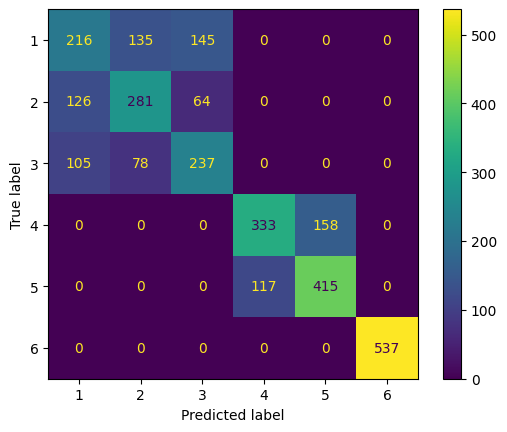

In [83]:
# Encontrando o índice da melhor árvore
best_tree_index = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1

# Selecionando a melhor árvore
best_tree = clfs[best_tree_index]

# Imprimindo a acurácia da melhor árvore na base de validação
print(f'Acurácia da melhor árvore na base de validação: {valid_scores[best_tree_index] * 100:.2f}%')

# Selecionando apenas as três variáveis mais importantes na base de testes
X_test_top3 = X_test[['53 tGravityAcc-min()-X', '390 fBodyAccJerk-bandsEnergy()-1,16', '42 tGravityAcc-mean()-Y']]

# Calculando a acurácia na base de testes
accuracy_test = best_tree.score(X_test_top3, y_test)

# Imprimindo a acurácia da melhor árvore na base de testes
print(f'Acurácia da melhor árvore na base de testes: {accuracy_test * 100:.2f}%')

# Exibindo a matriz de confusão

ConfusionMatrixDisplay.from_estimator(estimator=best_tree, X=X_test_top3, y=y_test)


> Os resultados mostram que a árvore de decisão tem uma acurácia de **89.45%** na base de validação e **68.51%** na base de testes. Isso sugere que o modelo está se saindo bem na base de validação, mas não tão bem na base de testes.

A diferença na acurácia entre a base de validação e a base de testes pode ser um indicativo de overfitting. Overfitting ocorre quando o modelo se ajusta muito bem aos dados de treinamento, mas não generaliza bem para novos dados. Isso pode acontecer quando o modelo é muito complexo e capta ruídos ou flutuações nos dados de treinamento como se fossem parte do padrão subjacente.
